In [13]:
# import stuff
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os

import scipy
from scipy import signal
import h5py, time
from iminuit import Minuit, describe
from pprint import pprint # we use this to pretty print some stuff later
import glob
import pandas as pd
import sys
sys.path.append('/home/analysis_user/New_trap_code/Tools/')
import BeadDataFile
from discharge_tools import *
from AnaUtil import *
from bisect import bisect_left
from tqdm import tqdm
import datetime as dt
plt.rcParams["figure.figsize"] = (12,9)
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.labelsize'] = "small"
plt.rcParams['ytick.labelsize'] = 36

In [14]:
# calibration of the voltage - position conversion

def voltage_to_position(voltage,slope=0.019834000085488412,offset=-0.0015000315197539749,redo=False):
    if(redo==True):
        pos_list=np.asarray([-0.007,4.968,9.91])
        y_err=np.asarray([0.01,0.01,0.01])
        val = np.asarray([0,250,500])
        data_x=val
        data_y=pos_list
        data_y_error=y_err
        m2=Minuit(chisquare_linear, 
             a = 100,
             b=0,
             errordef = 1,
             print_level=1)
        m2.migrad()
        print(m2.values["a"],m2.values["b"])
        plt.plot(val,pos_list,marker="*")
        plt.plot(val,m2.values["a"]*val+m2.values["b"])
        slope = m2.values["a"]
        offset = m2.values["b"]
    position=(voltage-offset)/slope
    return position

In [15]:
def sin_fit(data_x,params=list):
    return params[0] * np.sin(2*np.pi*params[1]*data_x+params[2]) + params[3]

def chisquare_1d(function, functionparams, data_x, data_y,data_y_error):
    chisquarevalue=np.sum(np.power(np.divide(np.subtract(function(data_x,functionparams),data_y),data_y_error),2))
    ndf = len(data_y)-len(functionparams)
    #print(ndf)
    return (chisquarevalue, ndf)

def chisquare_sin(a,b,c,d):
    return chisquare_1d(function=sin_fit,functionparams=[a,b,c,d],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]


In [16]:
# calibration of the voltage - position conversion

def voltage_to_position(voltage,slope=0.019834000085488412,offset=-0.0015000315197539749,redo=False):
    if(redo==True):
        pos_list=np.asarray([-0.007,4.968,9.91])
        y_err=np.asarray([0.01,0.01,0.01])
        val = np.asarray([0,250,500])
        data_x=val
        data_y=pos_list
        data_y_error=y_err
        m2=Minuit(chisquare_linear, 
             a = 100,
             b=0,
             errordef = 1,
             print_level=1)
        m2.migrad()
        print(m2.values["a"],m2.values["b"])
        plt.plot(val,pos_list,marker="*")
        plt.plot(val,m2.values["a"]*val+m2.values["b"])
        slope = m2.values["a"]
        offset = m2.values["b"]
    position=(voltage-offset)/slope
    return position

def extract_freq_and_stroke():
    stroke = voltage_to_position(np.std(files[0].cant_pos[1])*np.sqrt(2))
    return 2*stroke

In [17]:
Year = "2019"
Month = "12"
Day = "15"
BeadNumber =1
folder_basic = r"/data/new_trap/"+ Year + Month + Day + "/Bead"+str(BeadNumber)

In [18]:
distances = 362
folder_shaking = "/Shaking/Shaking%d/" %distances
folder = folder_basic + folder_shaking

In [19]:
files = load_dir_sorted(folder, file_prefix ="Shaking0_", max_file=100)

100  files in folder
100  files loaded


In [20]:
files[0].feedback[2]

array([ -916,  -910,  -898, ..., -1054, -1073, -1092], dtype=int32)

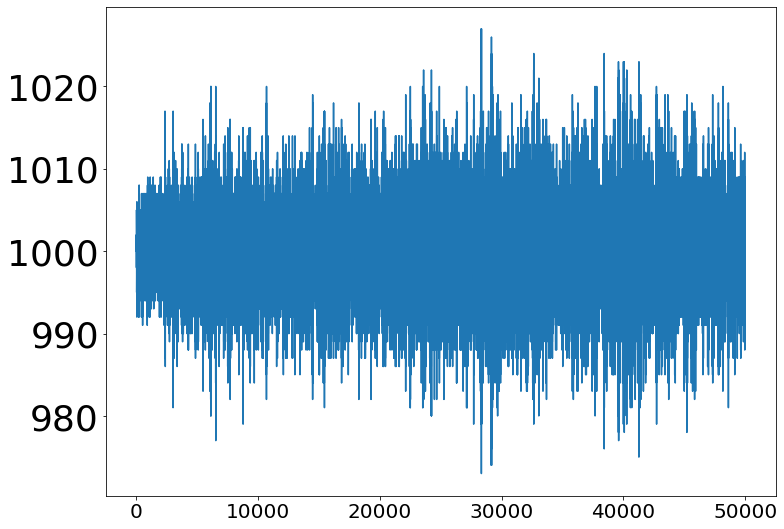

In [35]:
plt.plot(files[95].feedback[1])
#plt.ylim(-1250,1050)

In [ ]:
import datetime as dt

def get_temperature_and_pressure(date,from_hour,to_hour):
    f=[]
    for i in np.arange(from_hour,to_hour+1,1):
        if(i<10):
            hour = "0%d" %i
        if(i>9):
            hour ="%d" %i
        f.append(h5py.File("/data/SC_data/TemperatureAndPressure%s/TempAndPressure%s_%s.hdf5" %(date,date,hour)))
        print("/data/SC_data/TemperatureAndPressure%s/TempAndPressure%s_%s.hdf5" %(date,date,hour))
    airtemperature_list = []
    surfacetemperature_list = []
    pressure_list = []
    for i in np.arange(0,len(f),1):
        airtemperature_list.extend(list(f[i]["AirTemperature/AirTemperatures"]))
        surfacetemperature_list.extend(list(f[i]["SurfaceTemperature/SurfaceTemperatures"]))
        pressure_list.extend(list(f[i]["Pressure/Pressures"]))
    [f_.close() for f_ in f] ## good programing       
    return airtemperature_list, surfacetemperature_list, pressure_list

def from_timestamp_to_temperature(start_time,end_time):
    transform_time_start = dt.datetime.fromtimestamp(start_time/1e9)
    transform_time_end = dt.datetime.fromtimestamp(end_time/1e9)
    year = "%d" %transform_time_start.year
    if(transform_time_start.month<10):month="0"+ "%d"%transform_time_start.month
    else:month="%d"%transform_time_start.month
    if(transform_time_start.day<10):day="0"+ "%d"%transform_time_start.day
    else:day="%d"%transform_time_start.day
    date = year + month + day
    from_hour = transform_time_start.hour
    to_hour = transform_time_end.hour
    print(date,from_hour,to_hour)
    airtemperature_list, surfacetemperature_list, pressure_list = get_temperature_and_pressure(date,from_hour,to_hour)
    starting_point = transform_time_start.minute * 60 + transform_time_start.second
    end_point = transform_time_end.minute * 60 + transform_time_end.second
    print(starting_point,end_point)
    return airtemperature_list[starting_point:-end_point], surfacetemperature_list[starting_point:-end_point], pressure_list[starting_point:-end_point]